# PyPSA Beispiel 4

### In einem Zukunftsszenario  gestalten Sie die Energieversorgung einer kleinen Kommune. Dafür haben die einen Freiflächen-Solarpark mit 6 MW bauen lassen und sind zudem ans öffentliche Stromnetz angeschlossen. Sie haben bei der Ausschreibung für den Solarpark einen Zuschlagspreis von 6ct/kWh erhalten. Die Wärmeversorgung läuft über ein Nahwärmenetz welches aus einem BHKW und einem Gaskessel gespeist wird. Diese sind zunächst an das Erdgasnetz angeschlossen.

### Um die Energieversorgung nachhaltiger zu gestalten überlegen Sie eine Sektorenkopplung mittels Wasserstoff durchzuführen. Dafür möchten Sie die Anschaffung eines Elektrolyseurs und eines Wasserstoffspeichers prüfen. Das BHKW und der Gaskessel wurden vor kurzem modernisiert und als H2-ready gekennzeichnet und können mit jeder Kombination des Gemischs aus Erdgas und Wasserstoff betrieben werden. 

### Simulieren Sie das System um sehen ob die Wasserstoffintegration wirtschaftlich wäre und in welcher Größenordnung die Leistung der beteiligten Komponenten maximal benötigt werden würde.

### Eine Auswertungsfunktion soll diese Ergebnisse in einem DataFrame automatisch abspeichern.


### Führen Sie eine Sensitivitätsanalyse bezüglich der CO2 Emissionen des Systems durch. In dieser sollen die CO2 Emissionen vom Emissionswert der Simulation ohne Beschränkung dabei Schrittweise um 10 Prozentpunkte auf schlussendlich 0 gesenkt werden.

<div>
<img src="skizze_beispiel4.png" width="700"/>
</div>

Importieren Sie zunächst die notwendigen Bibliotheken

In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Schreiben Sie nun die Auswertungsfunktion

In [2]:
def analysis_of_network(network, sensitivity_variable = 0):
    
    #co2 Calculation
    co2 = (network.generators_t.p.sum() / network.generators.efficiency * 
         pd.merge(network.carriers, network.generators.carrier, 
                  left_index = True, 
                  right_on = 'carrier')['co2_emissions']).sum()
    
    #Invest Calculation 
    invest_links      = (network.links.p_nom_opt * network.links.capital_cost).sum()
    invest_stores     = (network.stores.e_nom_opt * network.stores.capital_cost).sum()
    invest_generators = (network.generators.p_nom_opt * network.generators.capital_cost).sum()
    total_invest      = round(invest_links + invest_stores + invest_generators)
    
    #Running Cost Calculation
    running_cost = round((network.generators_t.p.sum() * 
                          network.generators.marginal_cost).sum())
    #Optimal Capacity
    links_opt = [list(network.links.p_nom_opt.values)]
    link_opt_names = list(network.links.index)
    generators_opt = [list(network.generators.p_nom_opt.values)]
    generators_opt_names = list(network.generators.index)
    stores_opt     = [list(network.stores.e_nom_opt.values)]
    stores_opt_names     = list(network.stores.index)
    
    
    results = pd.concat([pd.DataFrame(data = total_invest, index = [sensitivity_variable], columns= ['total invest in €/a']),
                        pd.DataFrame(data = running_cost, index = [sensitivity_variable], columns= ['running cost in €/a']),
                        pd.DataFrame(data = co2, index = [sensitivity_variable], columns = ['CO2_emissions in kg/a']),
                        pd.DataFrame(data = links_opt, index = [sensitivity_variable], columns = link_opt_names), 
                        pd.DataFrame(data = generators_opt, index = [sensitivity_variable], columns = generators_opt_names),
                        pd.DataFrame(data = stores_opt, index = [sensitivity_variable], columns = stores_opt_names)],
                         axis = 1)
    
    return results

Laden Sie die PV-Erzeungungsdaten aus der Datei PV-Data.csv, sowie die Lastdaten aus der Datei load_data.xlsx.

Hinweis: Bei einer Fehlermeldung schauen Sie sich die csv-Datei an und suchen in der Dokumentation nach den entsprechenden benötigten Argumenten.

In [3]:
pv_data = pd.read_csv('PV_Data.csv', skiprows = 3)['electricity']
load_data = pd.read_excel('load_data.xlsx')

In [4]:
load_data

,Heizlast_kW,electric_load_kW
0,944.822373,433.394433
1,1259.763165,1030.247247
2,1511.715797,542.903496
3,1889.644747,584.443050
4,2204.585538,524.573043
...,...,...
8755,1018.718961,541.103607
8756,955.049026,851.679268
8757,955.049026,424.584448
8758,1018.718961,641.944782


Folgende technische/finanzielle Angaben sind Ihnen bekannt: <br> 
Ergänzen Sie die nötigen Angaben

In [5]:
electricity_rate = 0.4  #€/kWh
gas_rate         = 0.14  #€/kWh
grid_infeed      = -0.06 #€/kWh

efficiency_electrolysis     = 0.7 #decimal
efficiency_chp_thermal     = 0.6  #decimal
efficiency_chp_electrical  = 0.33 #decimal
efficiency_gas_boiler      = 0.95 #decimal

#electrolyser_p_min_pu = 0.3

pv_p_nom = 6000 #kW
chp_p_nom = 2000/efficiency_chp_thermal
gas_boiler_p_nom = 2000/efficiency_gas_boiler
infeed_p_nom = 7000

co2_emissions_germany_electricity  = 0.375 #kg/kWh
co2_emissions_natural_gas          = 0.274 #kg/kWh

capital_cost_electrolysis = 200 #€/kW as anuity
capital_cost_hydrogen_storage = 50 #€/kWh as anuity

Implementieren Sie das System und führen Sie eine Optimierung durch.

In [6]:
override_component_attrs = pypsa.descriptors.Dict(
    {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
)
override_component_attrs["Link"].loc["bus2"] = [
    "string",
    np.nan,
    np.nan,
    "2nd bus",
    "Input (optional)",
]
override_component_attrs["Link"].loc["efficiency2"] = [
    "static or series",
    "per unit",
    1.0,
    "2nd bus efficiency",
    "Input (optional)",
]
override_component_attrs["Link"].loc["p2"] = [
    "series",
    "MW",
    0.0,
    "2nd bus output",
    "Output",
]

In [7]:
network = pypsa.Network(override_component_attrs = override_component_attrs)
network.set_snapshots(range(8760))

network.add('Carrier', name = 'german_electricity', 
            co2_emissions = co2_emissions_germany_electricity)
network.add('Carrier', name = 'natural_gas', 
            co2_emissions = co2_emissions_natural_gas)

network.add('Bus', name = 'electricity')
network.add('Bus', name = 'el_infeed')
network.add('Bus', name = 'heat')
network.add('Bus', name = 'natural_gas')
network.add('Bus', name = 'hydrogen')

network.add('Generator', name = 'PV', bus = 'el_infeed', p_nom = pv_p_nom,
           p_max_pu = pv_data)
network.add('Generator', name = 'grid_infeed', bus = 'el_infeed', sign = -1,
           p_nom = infeed_p_nom, marginal_cost = grid_infeed)
network.add('Generator', name = 'grid_power', bus = 'electricity', 
            marginal_cost = electricity_rate, p_nom_extendable = True,
           carrier = 'german_electricity')
network.add('Generator', name = 'natural_gas_grid', bus = 'natural_gas',
           p_nom_extendable = True, marginal_cost = gas_rate,
           carrier = 'natural_gas')


network.add('Load', name = 'el_load', bus = 'electricity', 
            p_set =  load_data['electric_load_kW'])
network.add('Load', name = 'thermal_load', bus = 'heat', 
            p_set = load_data['Heizlast_kW'])


network.add('Link', name = 'power_self_consumption', bus0 = 'el_infeed',
           bus1 = 'electricity', p_nom_extendable = True)
network.add('Link', name = 'gas_boiler', bus0 = 'natural_gas',
           bus1 = 'heat', p_nom = gas_boiler_p_nom, 
            efficiency = efficiency_gas_boiler)
network.add('Link', name = 'chp', bus0 = 'natural_gas', bus1 = 'heat', 
            bus2 = 'el_infeed', p_nom = chp_p_nom, 
            efficiency = efficiency_chp_thermal, 
            efficiency2 = efficiency_chp_electrical)
network.add('Link', name = 'electrolysis', bus0 = 'electricity', 
            bus1 = 'hydrogen', efficiency = efficiency_electrolysis,
           p_nom_extendable = True, capital_cost = capital_cost_electrolysis)
network.add('Link', name = 'h2_to_natural_gas', bus0 = 'hydrogen', 
            bus1 = 'natural_gas', p_nom_extendable = True )

network.add('Store', name = 'hydrogen_store', bus = 'hydrogen', 
           capital_cost = capital_cost_hydrogen_storage, 
           e_nom_extendable = True)

In [8]:
network.optimize(solver_name = 'gurobi', threads = 1, method = 0)

INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - threads: 1
 - method: 0
Writing variables.: 100%|██████████| 7/7 [00:00<00:00, 48.03it/s]

Set parameter ServerTimeout to value 10
Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-br_pq4ks.lp
Reading time = 0.46 seconds
obj: 227766 rows, 96366 columns, 394205 nonzeros
Set parameter Threads to value 1
Set parameter Method to value 0
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 12 physical cores, 12 logical processors, using up to 1 threads

Optimize a model with 227766 rows, 96366 columns and 394205 nonzeros
Model fingerprint: 0x3440e0dc
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [6e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 180760 rows and 36274 columns
Presolve time: 0.25s
Presolved: 47006 rows, 60092 columns, 133042 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.1335690e+06   0.000000e+00   6.011697e+04      0s
   22077    1.3556497e+06   0.000000e+00   0.000000e+0

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96366 primals, 227766 duals
Objective: 1.36e+06
Solver model: available
Solver message: 2



('ok', 'optimal')

Schauen sie sich mit "network.generators_t.p.plot()" und network.links_t.p0.plot() an, wie die Last über das Jahr abgedeckt wird

<AxesSubplot: xlabel='snapshot'>

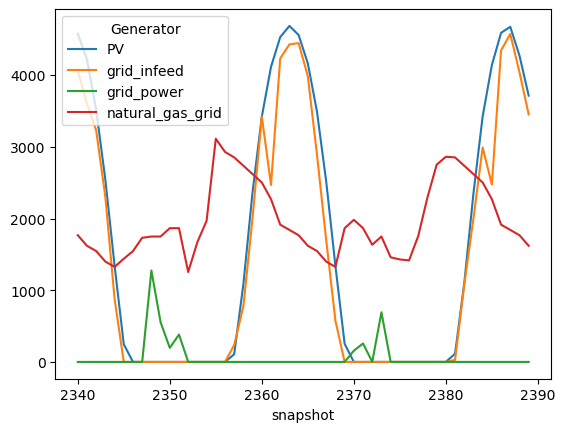

In [9]:
network.generators_t.p[2340:2390].plot()

<AxesSubplot: xlabel='snapshot'>

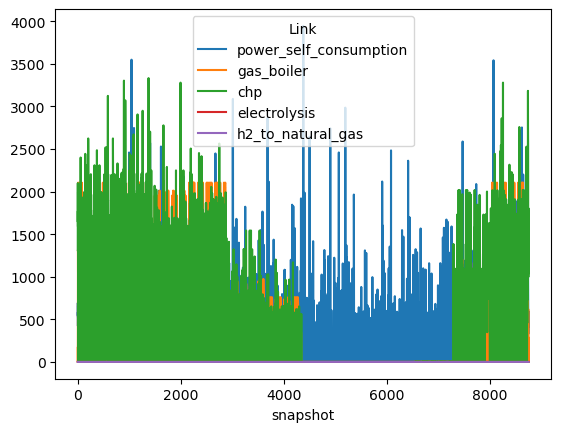

In [10]:
network.links_t.p0.plot()

Lassen Sie sich die optimale Größe des Elektrolyseurs und des H2-Speichers ausgeben.

In [11]:
network.stores.e_nom_opt

Store
hydrogen_store    0.0
Name: e_nom_opt, dtype: float64

Lassen Sie sich das Verhalten des Elektrolyseurs und des H2-Speichers darstellen.

Führen Sie die Sensitivitätsanalyse für die CO2 Emissionen aus. (Bereich bis 90 % in 5 % Schritten)

In [12]:
network.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
            carrier_attribute = 'co2_emissions', constant = np.inf)

network.optimize(solver_name = 'gurobi', threads = 1, method = 0, 
                snapshots = network.snapshots[0:1000])


INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - threads: 1
 - method: 0
Writing variables.: 100%|██████████| 7/7 [00:00<00:00, 189.67it/s]

Read LP format model from file /tmp/linopy-problem-hbsns9te.lp
Reading time = 0.05 seconds
obj: 26007 rows, 11006 columns, 47005 nonzeros
Set parameter Threads to value 1
Set parameter Method to value 0
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 12 physical cores, 12 logical processors, using up to 1 threads

Optimize a model with 26007 rows, 11006 columns and 47005 nonzeros
Model fingerprint: 0xfcdc2c06
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [6e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 20128 rows and 3245 columns
Presolve time: 0.03s
Presolved: 5879 rows, 7761 columns, 16578 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.6203


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11006 primals, 26007 duals
Objective: 2.95e+05
Solver model: available
Solver message: 2



('ok', 'optimal')

In [13]:
results = analysis_of_network(network, 100)
basis_co2_emissions = results['CO2_emissions in kg/a']


In [14]:
basis_co2_emissions

100    2.747887e+06
Name: CO2_emissions in kg/a, dtype: float64

In [15]:
for co2_limit in np.flip(np.arange(0.9, 1, 0.05)):
    network.global_constraints.loc['co2-limit', 'constant'] = (co2_limit * basis_co2_emissions.values)
    network.optimize(solver_name = 'gurobi', threads = 1, method = 0, 
                snapshots = network.snapshots[0:1000])
    results = results.append(analysis_of_network(network, co2_limit * 100))

INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - threads: 1
 - method: 0
Writing variables.: 100%|██████████| 7/7 [00:00<00:00, 196.83it/s]

Read LP format model from file /tmp/linopy-problem-qnqd2o2_.lp
Reading time = 0.06 seconds
obj: 26007 rows, 11006 columns, 47005 nonzeros
Set parameter Threads to value 1
Set parameter Method to value 0
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 12 physical cores, 12 logical processors, using up to 1 threads

Optimize a model with 26007 rows, 11006 columns and 47005 nonzeros
Model fingerprint: 0x4e020b9c
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [6e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 3e+06]
Presolve removed 20067 rows and 3125 columns
Presolve time: 0.03s
Presolved: 5940 rows, 7881 columns, 18818 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6357371e+05   1.508098e+05   2.177644e+09      0s


    4739    2.9519383e+05   0.000000e+00   0.000000e+00      0s

Solved in 4739 iterations and 0.39 seconds (0.43 work units)
Optimal objective  2.951938308e+05


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11006 primals, 26007 duals
Objective: 2.95e+05
Solver model: available
Solver message: 2

/tmp/ipykernel_65/3385861424.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - threads: 1
 - method: 0
Writing variables.: 100%|██████████| 7/7 [00:00<00:00, 193.23it/s]

Read LP format model from file /tmp/linopy-problem-rzi5h1rl.lp
Reading time = 0.06 seconds
obj: 26007 rows, 11006 columns, 47005 nonzeros
Set parameter Threads to value 1
Set parameter Method to value 0
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 12 physical cores, 12 logical processors, using up to 1 threads

Optimize a model with 26007 rows, 11006 columns and 47005 nonzeros
Model fingerprint: 0x88a0022d
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [6e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 2e+06]
Presolve removed 20067 rows and 3125 columns
Presolve time: 0.03s
Presolved: 5940 rows, 7881 columns, 18818 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6357371e+05   1.508098e+05   2.177644e+09      0s


    4739    2.9519383e+05   0.000000e+00   0.000000e+00      0s

Solved in 4739 iterations and 0.39 seconds (0.43 work units)
Optimal objective  2.951938308e+05


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11006 primals, 26007 duals
Objective: 2.95e+05
Solver model: available
Solver message: 2

/tmp/ipykernel_65/3385861424.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [16]:
results

,total invest in €/a,running cost in €/a,CO2_emissions in kg/a,power_self_consumption,gas_boiler,chp,electrolysis,h2_to_natural_gas,PV,grid_infeed,grid_power,natural_gas_grid,hydrogen_store
100.0,0,1355650,2.747887e+06,2459.643663,2105.263158,3333.333333,0.0,0.0,6000.0,7000.0,5405.105592,3552.255472,0.0
95.0,0,1355650,2.747887e+06,2459.643663,2105.263158,3333.333333,0.0,0.0,6000.0,7000.0,5405.105592,3552.255472,0.0
90.0,0,1355650,2.747887e+06,2459.643663,2105.263158,3333.333333,0.0,0.0,6000.0,7000.0,5405.105592,3552.255472,0.0


#### CO2 Neutralität
Wie Sie sicher festgestellt haben ist eine CO2-Reduktion mit den bisher installierten Komponenten nur in geringem Maße möglich. Dazu ist die durch die PV Anlage erzeugte Energie zu gering.
Um die Emissionen noch weiter zu senken, soll geprüft werden wie viel zusätzliche PV-Kapazität benötigt wird. Außerdem soll ein Batteriespeicher das System ergänzen. Eine weitere Option für die Gemeinde ist die Installation einer Windkraftanlage.

Fügen Sie die neuen Komponenten hinzu und prüfen Sie, wie weit die Emissionen jetzt gesenkt werden können. 
* Welche Leistungen und Kapazitäten dazu installiert werden müssten. 
* Sind die optimierten Werte realistisch?

In [17]:
# Zusätzliche Angaben
wind_data = pd.read_csv('ninja_wind_data.csv', skiprows = 3)['electricity']

capital_cost_pv = 1750/20 # €/kW
capital_cost_battery = 1200/20 #€/kWh
capital_cost_wind = 1400 / 27 # €/kWp https://pubs.rsc.org/en/content/articlehtml/2022/ee/d2ee01023b

In [18]:
# Komponenten
network.add('Store', bus = 'electricity', name= 'battery', 
            e_cyclic = True, e_nom_extendable = True, 
            capital_cost = capital_cost_battery)
network.add('Generator', name = 'PV_add', bus = 'el_infeed', 
            p_nom_extendable = True, p_max_pu = pv_data, 
            capital_cost = capital_cost_pv)
network.add('Generator', name = 'Wind_add', bus = 'electricity', 
            p_nom_extendable = True, p_max_pu = wind_data, capital_cost = capital_cost_wind)


Führen Sie eine erneute Sensitivitätsanalyse der CO2 Emissionen durch.

In [21]:
network.global_constraints.loc['co2-limit', 'constant'] = np.inf

network.optimize(solver_name = 'gurobi', threads = 1, method = 0)#, 
                #snapshots = network.snapshots[0:4000])

results = analysis_of_network(network, 100)
basis_co2_emissions = results['CO2_emissions in kg/a'].values

for co2_limit in np.flip(np.arange(0.0, 1, 0.2)):
    print(co2_limit* basis_co2_emissions)
    network.global_constraints.loc['co2-limit', 'constant'] = (co2_limit * basis_co2_emissions)
    network.optimize(solver_name = 'gurobi', threads = 1, method = 0)#, 
                #snapshots = network.snapshots[0:4000])
    results = results.append(analysis_of_network(network, co2_limit * 100))

INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - threads: 1
 - method: 0
Writing variables.: 100%|██████████| 7/7 [00:00<00:00, 41.47it/s]


Read LP format model from file /tmp/linopy-problem-3ul6bid7.lp
Reading time = 0.61 seconds
obj: 289090 rows, 131409 columns, 538738 nonzeros
Set parameter Threads to value 1
Set parameter Method to value 0
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 12 physical cores, 12 logical processors, using up to 1 threads

Optimize a model with 289090 rows, 131409 columns and 538738 nonzeros
Model fingerprint: 0x7ea0e2da
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [6e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 217845 rows and 41844 columns
Presolve time: 0.33s
Presolved: 71245 rows, 89565 columns, 217741 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131409 primals, 289090 duals
Objective: 1.00e+06
Solver model: available
Solver message: 2



[1377199.37205535]


INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - threads: 1
 - method: 0
Writing variables.: 100%|██████████| 7/7 [00:00<00:00, 36.57it/s]


Read LP format model from file /tmp/linopy-problem-j6rsb2gl.lp
Reading time = 0.58 seconds
obj: 289090 rows, 131409 columns, 538738 nonzeros
Set parameter Threads to value 1
Set parameter Method to value 0
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 12 physical cores, 12 logical processors, using up to 1 threads

Optimize a model with 289090 rows, 131409 columns and 538738 nonzeros
Model fingerprint: 0xc5001130
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [6e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+06]
Presolve removed 217844 rows and 41844 columns
Presolve time: 1.44s
Presolved: 71246 rows, 89565 columns, 233773 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1650683e+10   0.000000e+00   4.033862e+07      2s
    2466    7.9391217e+09   0.000000e+00   1.592630e

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131409 primals, 289090 duals
Objective: 1.02e+06
Solver model: available
Solver message: 2

/tmp/ipykernel_65/2493446250.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



[1032899.52904151]


INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - threads: 1
 - method: 0
Writing variables.: 100%|██████████| 7/7 [00:00<00:00, 36.34it/s]


Read LP format model from file /tmp/linopy-problem-42mc3lcw.lp
Reading time = 1.60 seconds
obj: 289090 rows, 131409 columns, 538738 nonzeros
Set parameter Threads to value 1
Set parameter Method to value 0
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 12 physical cores, 12 logical processors, using up to 1 threads

Optimize a model with 289090 rows, 131409 columns and 538738 nonzeros
Model fingerprint: 0x7e3dceb5
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [6e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+06]
Presolve removed 217844 rows and 41844 columns
Presolve time: 2.18s
Presolved: 71246 rows, 89565 columns, 233773 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1650633e+10   0.000000e+00   4.033828e+07      3s
    2073    8.4703121e+09   0.000000e+00   1.850010e

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131409 primals, 289090 duals
Objective: 1.10e+06
Solver model: available
Solver message: 2

/tmp/ipykernel_65/2493446250.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



[688599.68602768]


INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - threads: 1
 - method: 0
Writing variables.: 100%|██████████| 7/7 [00:00<00:00, 36.72it/s]


Read LP format model from file /tmp/linopy-problem-nu26qvw3.lp
Reading time = 0.64 seconds
obj: 289090 rows, 131409 columns, 538738 nonzeros
Set parameter Threads to value 1
Set parameter Method to value 0
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 12 physical cores, 12 logical processors, using up to 1 threads

Optimize a model with 289090 rows, 131409 columns and 538738 nonzeros
Model fingerprint: 0xd1962b1a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [6e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+05]
Presolve removed 217844 rows and 41844 columns
Presolve time: 0.51s
Presolved: 71246 rows, 89565 columns, 233773 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1650198e+10   0.000000e+00   4.033935e+07      1s
    2865    6.8168695e+09   0.000000e+00   1.291464e

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131409 primals, 289090 duals
Objective: 1.31e+06
Solver model: available
Solver message: 2

/tmp/ipykernel_65/2493446250.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



[344299.84301384]


INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - threads: 1
 - method: 0
Writing variables.: 100%|██████████| 7/7 [00:00<00:00, 37.50it/s]


Read LP format model from file /tmp/linopy-problem-5yv64mxl.lp
Reading time = 0.60 seconds
obj: 289090 rows, 131409 columns, 538738 nonzeros
Set parameter Threads to value 1
Set parameter Method to value 0
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 12 physical cores, 12 logical processors, using up to 1 threads

Optimize a model with 289090 rows, 131409 columns and 538738 nonzeros
Model fingerprint: 0xbd194cd8
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [6e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 3e+05]
Presolve removed 217844 rows and 41844 columns
Presolve time: 0.37s
Presolved: 71246 rows, 89565 columns, 233773 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1652824e+10   0.000000e+00   4.033828e+07      1s
    3002    2.8185406e+09   0.000000e+00   5.448181e

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131409 primals, 289090 duals
Objective: 1.79e+06
Solver model: available
Solver message: 2

/tmp/ipykernel_65/2493446250.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



[0.]


INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - threads: 1
 - method: 0
Writing variables.: 100%|██████████| 7/7 [00:00<00:00, 34.97it/s]


Read LP format model from file /tmp/linopy-problem-itu64oxq.lp
Reading time = 0.65 seconds
obj: 289090 rows, 131409 columns, 538738 nonzeros
Set parameter Threads to value 1
Set parameter Method to value 0
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 12 physical cores, 12 logical processors, using up to 1 threads

Optimize a model with 289090 rows, 131409 columns and 538738 nonzeros
Model fingerprint: 0x4f614ac5
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [6e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 225117 rows and 65148 columns
Presolve time: 0.47s
Presolved: 63973 rows, 66261 columns, 187165 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1654085e+10   0.000000e+00   1.727008e+07      1s
    9619    2.2906821e+08   0.000000e+00   3.342426e

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131409 primals, 289090 duals
Objective: 5.47e+06
Solver model: available
Solver message: 2

/tmp/ipykernel_65/2493446250.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Stellen Sie die Ergebnisse grafisch dar anschaulich dar und achten Sie auf eine passende Achsenbezeichnung. <br>(Hinweis: Nutzen Sie dafür die Bibliothek matplotlib.pyplot)

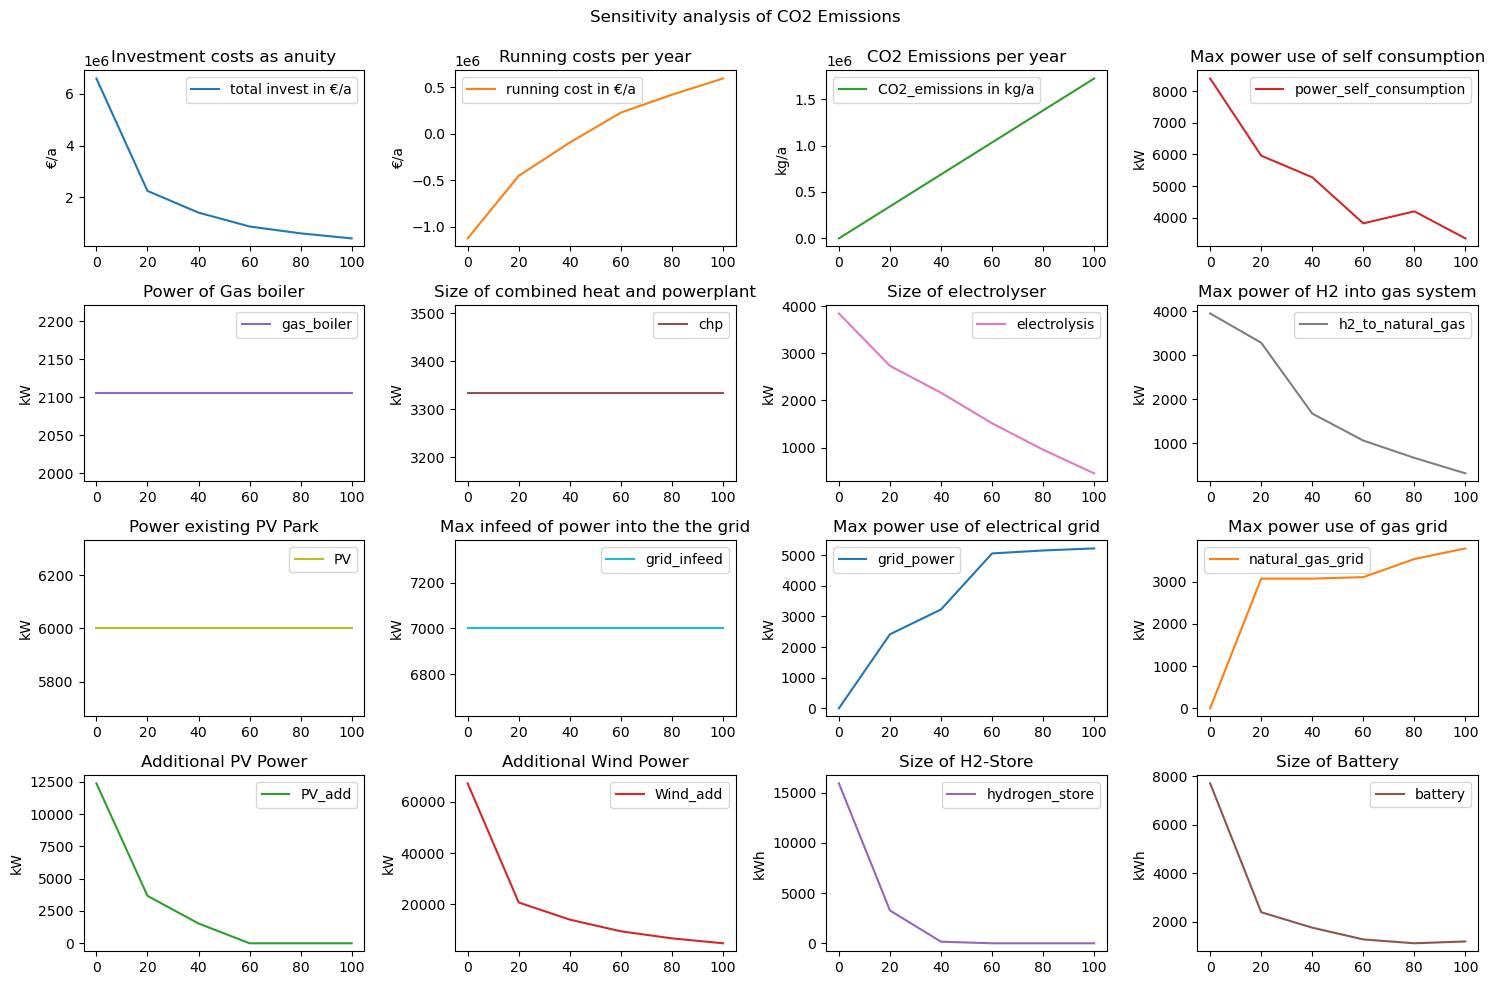

In [23]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize = (15,10))
results.plot(subplots=True, ax=axes)

axes[0,0].set_ylabel('€/a')
axes[0,1].set_ylabel('€/a')
axes[0,2].set_ylabel('kg/a')
axes[0,3].set_ylabel('kW')
axes[1,0].set_ylabel('kW')
axes[1,1].set_ylabel('kW')
axes[1,2].set_ylabel('kW')
axes[1,3].set_ylabel('kW')
axes[2,0].set_ylabel('kW')
axes[2,1].set_ylabel('kW')
axes[2,2].set_ylabel('kW')
axes[2,3].set_ylabel('kW')
axes[3,0].set_ylabel('kW')
axes[3,1].set_ylabel('kW')
axes[3,2].set_ylabel('kWh')
axes[3,3].set_ylabel('kWh')

axes[0,0].set_title('Investment costs as anuity')
axes[0,1].set_title('Running costs per year')
axes[0,2].set_title('CO2 Emissions per year')
axes[0,3].set_title('Max power use of self consumption')
axes[1,0].set_title('Power of Gas boiler')
axes[1,1].set_title('Size of combined heat and powerplant')
axes[1,2].set_title('Size of electrolyser')
axes[1,3].set_title('Max power of H2 into gas system')
axes[2,0].set_title('Power existing PV Park')
axes[2,1].set_title('Max infeed of power into the the grid')
axes[2,2].set_title('Max power use of electrical grid')
axes[2,3].set_title('Max power use of gas grid')
axes[3,0].set_title('Additional PV Power')
axes[3,1].set_title('Additional Wind Power')
axes[3,2].set_title('Size of H2-Store')
axes[3,3].set_title('Size of Battery')

fig.suptitle('Sensitivity analysis of CO2 Emissions')
fig.tight_layout()